In [1]:
import os
import os.path as op
import numpy as np
import re
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter
from pathlib import Path
from scipy.stats import ttest_1samp

### Inspect column names

To fix some errors I made in writing the log files

In [2]:
root = Path('../data/logs/')
headers = {}
for file in root.rglob("*.log"):
    sub = int(re.findall('sub-(\d{1,2})', file.name)[0])
    sub_df = pd.read_csv(file)
    col_names = sub_df.columns.values.tolist()
    headers[sub] = col_names

headers = pd.DataFrame.from_dict(headers, orient='index')
headers = headers.sort_index()

In [3]:
headers.head()

# subs 1-8 have the right headings, just didn't record n_target_plays
# subs 9-12 have the right headings
# subs 13-31 have tone_num and n_target_plays in the wrong order
# subs 31- have the right headings

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
1,seed,sub_num,block_num,seq_num,target,tone_num,freq,mark,is_target,n_targets,response,correct,score,None
2,seed,sub_num,block_num,seq_num,target,tone_num,freq,mark,is_target,n_targets,response,correct,score,None
3,seed,sub_num,block_num,seq_num,target,tone_num,freq,mark,is_target,n_targets,response,correct,score,None
4,seed,sub_num,block_num,seq_num,target,tone_num,freq,mark,is_target,n_targets,response,correct,score,None
5,seed,sub_num,block_num,seq_num,target,tone_num,freq,mark,is_target,n_targets,response,correct,score,None


### Load data

In [4]:
root = Path('../data/logs/')
df = pd.DataFrame()
for file in root.rglob("*.log"):
    sub = int(re.findall('sub-(\d{1,2})', file.name)[0])
    sub_df = pd.read_csv(file)
    df = pd.concat([df, sub_df])
    if 13 <= sub <= 31:
        df = df.rename({'tone_num': 'n_target_plays', 'n_target_plays': 'tone_num'}, axis='columns')
# df.to_csv('../data/behavioral_data.csv')
df

,seed,sub_num,block_num,seq_num,target,tone_num,n_target_plays,freq,mark,is_target,n_targets,response,correct,score,n_target_plays.1
0,30000,30,0,1,130,3.0,1.0,280,13,0,14,15,1,1.0,NaN
1,30000,30,0,1,130,3.0,2.0,130,11,1,14,15,1,1.0,NaN
2,30000,30,0,1,130,3.0,3.0,130,11,1,14,15,1,1.0,NaN
3,30000,30,0,1,130,3.0,4.0,200,12,0,14,15,1,1.0,NaN
4,30000,30,0,1,130,3.0,5.0,130,11,1,14,15,1,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673,5040,5,4,19,200,26.0,NaN,280,23,0,9,9,2,18.0,NaN
674,5040,5,4,19,200,27.0,NaN,130,21,0,9,9,2,18.0,NaN
675,5040,5,4,19,200,28.0,NaN,130,21,0,9,9,2,18.0,NaN
676,5040,5,4,19,200,29.0,NaN,130,21,0,9,9,2,18.0,NaN


## Accuracies

In [33]:
df_scores = df[df.tone_num == 1] # Get only one trial per sequence to extract the score
df_scores = df_scores[['sub_num', 'block_num', 'target', 'n_target_plays', 'n_targets', 'response']]
df_scores['accuracy'] = 1 - abs(df_scores.n_targets - df_scores.response)/df_scores.n_targets
df_scores = df_scores[df_scores.block_num != 0]
df_scores.to_csv('../data/accuracy_by_trial.csv')
df_scores

,sub_num,block_num,target,n_target_plays,n_targets,response,accuracy
0,30,3,200,4.0,14,14,1.0
42,30,3,200,2.0,11,10,0.909091
78,30,3,130,3.0,9,9,1.0
114,30,3,280,2.0,12,13,0.916667
156,30,3,280,3.0,11,11,1.0
...,...,...,...,...,...,...,...
510,5,4,130,NaN,9,9,1.0
546,5,4,200,NaN,9,9,1.0
576,5,4,280,NaN,11,12,0.909091
606,5,4,200,NaN,12,14,0.833333


#### Histogram of accuracies across subjects

In [4]:
df_scores = pd.read_csv('../data/accuracy_by_trial.csv')

<Axes: xlabel='accuracy', ylabel='Count'>

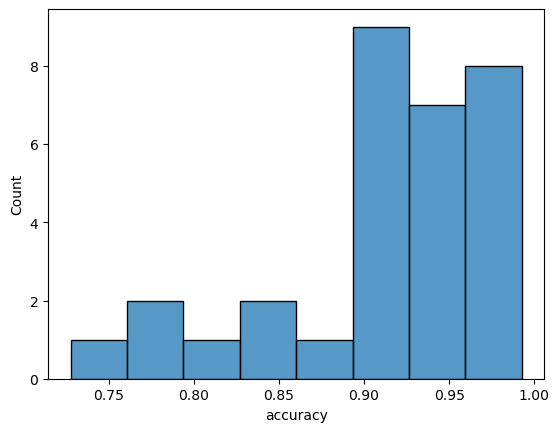

In [5]:
accuracies = df_scores.groupby('sub_num')['accuracy'].mean()
sns.histplot(accuracies)

#### Boxplots of accuracy by target

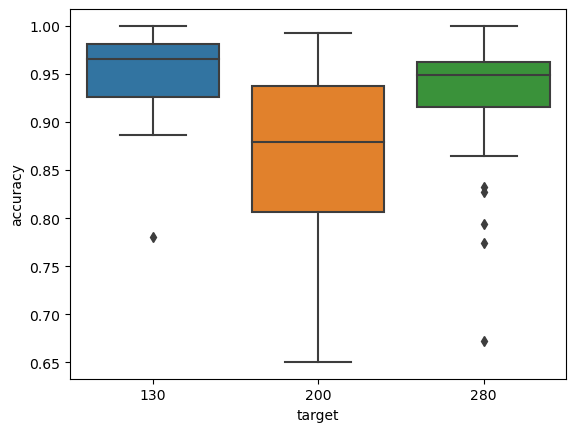

In [6]:
accuracies = df_scores.groupby(['sub_num', 'target'])['accuracy'].mean()
accuracies = pd.DataFrame(accuracies).reset_index()
sns.boxplot(data = accuracies, x = 'target', y = 'accuracy')
accuracies.to_csv('../data/accuracy_by_sub.csv')

#### Boxplots of accuracy by block

<Axes: xlabel='block_num', ylabel='accuracy'>

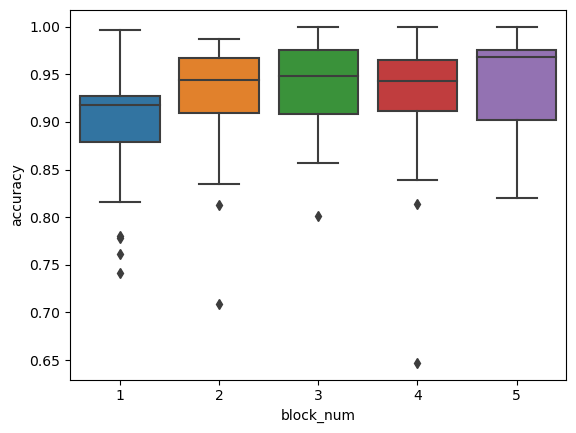

In [9]:
accuracies = df_scores.groupby(['sub_num', 'block_num'])['accuracy'].mean()
accuracies = pd.DataFrame(accuracies).reset_index()
accuracies = accuracies[accuracies.block_num < 6]
sns.boxplot(data = accuracies, x = 'block_num', y = 'accuracy')

## Target plays

In [10]:
# Clean data
df_plays = df[df.tone_num != 1]
df_plays = df_plays[['sub_num', 'block_num', 'target', 'n_target_plays']]
df_plays = df_plays[df_plays.n_target_plays < 50]
df_plays = df_plays[df_plays.block_num != 0]
df_plays = df_plays[df_plays.block_num != 6]
df_plays = df_plays.dropna()

# Calculate means by sub
df_plays = df_plays.groupby(['sub_num', 'target', 'block_num'])['n_target_plays'].mean()
df_plays = pd.DataFrame(df_plays).reset_index()

df_plays

,sub_num,target,block_num,n_target_plays
0,1,130,1,18.242857
1,1,130,2,18.443396
2,1,130,3,18.280488
3,1,130,5,19.464286
4,1,200,1,16.192308
...,...,...,...,...
357,31,280,1,5.447619
358,31,280,2,16.357143
359,31,280,3,3.262626
360,31,280,4,2.000000


#### Histogram of target plays across subjects

<Axes: xlabel='n_target_plays', ylabel='Count'>

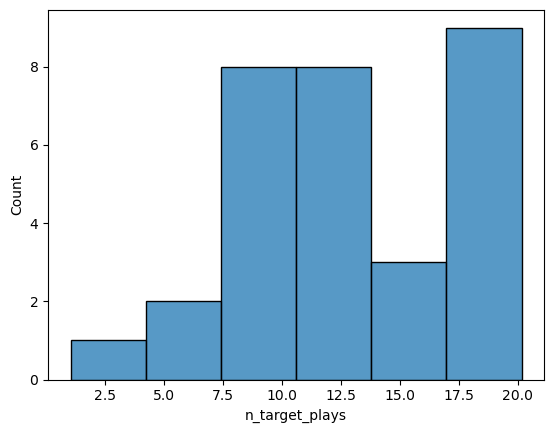

In [11]:
df_plays_hist = df_plays.groupby(['sub_num'])['n_target_plays'].mean()
sns.histplot(df_plays_hist)

#### Boxplots of target plays by target freq and block number

<Axes: xlabel='target', ylabel='n_target_plays'>

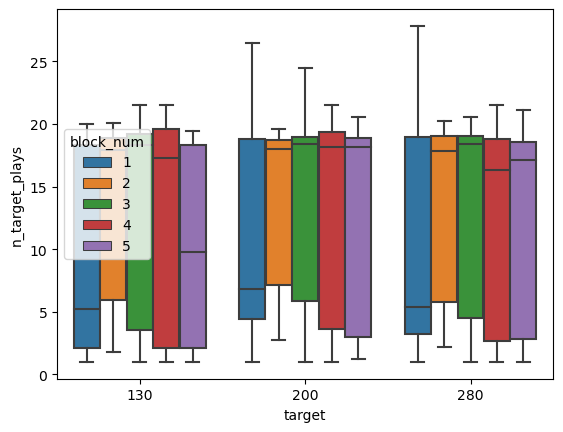

In [12]:
sns.boxplot(data = df_plays, x = 'target', y = 'n_target_plays', hue = 'block_num')

## Accuracy by target identity

In [24]:
accuracies

,sub_num,target,accuracy
0,1,130,0.924675
1,1,200,0.945455
2,1,280,0.979592
3,2,130,0.926885
4,2,200,0.863781
...,...,...,...
88,30,200,0.957965
89,30,280,0.980682
90,31,130,0.966254
91,31,200,0.879230


<Axes: xlabel='target', ylabel='accuracy'>

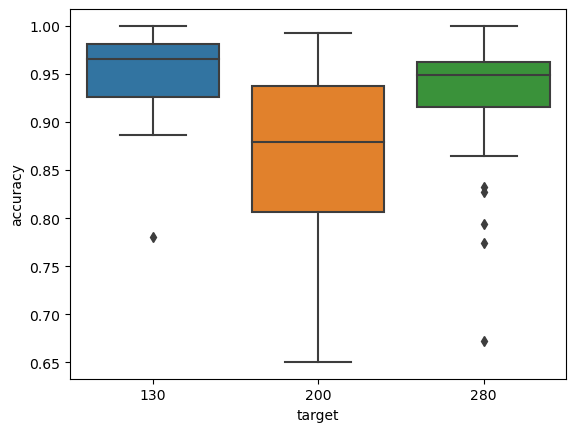

In [25]:
p = sns.boxplot(data = accuracies, x = 'target', y = 'accuracy')
p.set_ylim(0)

#### ANOVA

In [26]:
from statsmodels.stats.anova import AnovaRM
aov = AnovaRM(
    data = accuracies, 
    depvar = 'accuracy',
    subject = 'sub_num', 
    within = ['target']
)
res = aov.fit()
print(res)

               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
target 27.8999 2.0000 60.0000 0.0000



#### Pairwise t-tests

In [30]:
acc_130 = accuracies['accuracy'][accuracies['target'] == 130]
acc_200 = accuracies['accuracy'][accuracies['target'] == 200]
acc_280 = accuracies['accuracy'][accuracies['target'] == 280]

In [32]:
from scipy.stats import ttest_ind
print(ttest_ind(acc_130, acc_200))
print(ttest_ind(acc_130, acc_280))
print(ttest_ind(acc_200, acc_280))

Ttest_indResult(statistic=4.538127743543667, pvalue=2.7810076972824e-05)
Ttest_indResult(statistic=1.7582202244360667, pvalue=0.08380982118366796)
Ttest_indResult(statistic=-2.7689656111689076, pvalue=0.007470858151971651)


## Regressions

In [10]:
accuracies

,sub_num,target,accuracy
0,1,130,0.924675
1,1,200,0.945455
2,1,280,0.979592
3,2,130,0.926885
4,2,200,0.863781
...,...,...,...
88,30,200,0.957965
89,30,280,0.980682
90,31,130,0.966254
91,31,200,0.879230


In [12]:
spectrums = pd.read_csv('spectrums.csv', sep = '\t')
spectrums

,subject,target,stimulus,frequency,power
0,3,130,130,0.000000,5.289243
1,3,130,130,4.979253,5.347941
2,3,130,130,9.958506,5.533879
3,3,130,130,14.937759,5.417680
4,3,130,130,19.917012,5.271016
...,...,...,...,...,...
44644,45,280,280,577.593361,2.571565
44645,45,280,280,582.572614,2.259651
44646,45,280,280,587.551867,1.317281
44647,45,280,280,592.531120,2.590665


In [32]:
subs = np.unique(spectrums['subject'])
targets = [130, 200, 280]
reg_df = pd.DataFrame()

for sub in subs:
    for target in targets:
        # Get score for subject
        sub_accuracy = accuracies[(accuracies['sub_num'] == sub) & (accuracies['target'] == target)]
        sub_accuracy = sub_accuracy['accuracy']

        # Get FFR for subject
        sub_spectrums = spectrums[(spectrums['subject'] == sub) & (spectrums['target'] == target)].reset_index(drop = True)
        idx = np.abs(sub_spectrums.frequency - target).argmin()
        hz = sub_spectrums.frequency[idx]
        power_f0 = sub_spectrums[sub_spectrums.frequency == hz]
        power_f0 = power_f0[power_f0.stimulus == target]

        # Add score
        try:
            power_f0['accuracy'] = list(sub_accuracy)
        except:
            print(f'Missing data, skipping sub {sub}')
            continue

        # Concat to data frame
        reg_df = pd.concat([reg_df, power_f0])

reg_df = reg_df.reset_index(drop = True)
reg_df

Missing data, skipping sub 32
Missing data, skipping sub 32
Missing data, skipping sub 32
Missing data, skipping sub 33
Missing data, skipping sub 33
Missing data, skipping sub 33
Missing data, skipping sub 34
Missing data, skipping sub 34
Missing data, skipping sub 34
Missing data, skipping sub 35
Missing data, skipping sub 35
Missing data, skipping sub 35
Missing data, skipping sub 36
Missing data, skipping sub 36
Missing data, skipping sub 36
Missing data, skipping sub 37
Missing data, skipping sub 37
Missing data, skipping sub 37
Missing data, skipping sub 38
Missing data, skipping sub 38
Missing data, skipping sub 38
Missing data, skipping sub 39
Missing data, skipping sub 39
Missing data, skipping sub 39
Missing data, skipping sub 40
Missing data, skipping sub 40
Missing data, skipping sub 40
Missing data, skipping sub 41
Missing data, skipping sub 41
Missing data, skipping sub 41
Missing data, skipping sub 42
Missing data, skipping sub 42
Missing data, skipping sub 42
Missing da

,subject,target,stimulus,frequency,power,accuracy
0,3,130,130,129.460581,2.126778,0.903767
1,3,200,200,199.170124,14.143326,0.691818
2,3,280,280,278.838174,7.561676,0.774429
3,4,130,130,129.460581,3.763498,0.974835
4,4,200,200,199.170124,3.117015,0.919356
...,...,...,...,...,...,...
79,30,200,200,199.170124,5.335244,0.957965
80,30,280,280,278.838174,13.943993,0.980682
81,31,130,130,129.460581,-0.586451,0.966254
82,31,200,200,199.170124,-1.112449,0.879230


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


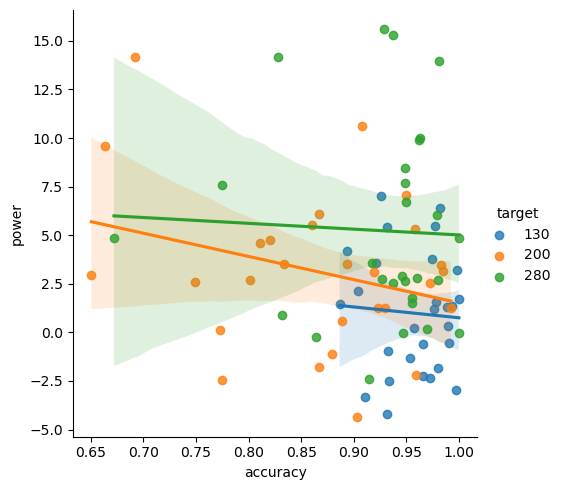

In [36]:
sns.lmplot(data = reg_df, x = "accuracy", y = "power", hue = 'target')
plt.show()

In [45]:
from scipy import stats
reg_df_cond = reg_df[reg_df['target'] == 130]
slope, intercept, r_value, p_value, std_err = stats.linregress(list(reg_df_cond['accuracy']), list(reg_df_cond['power']))
print(slope)
print(intercept)
print(r_value)
print(f'p: {p_value}')
print(std_err)

reg_df_cond = reg_df[reg_df['target'] == 200]
slope, intercept, r_value, p_value, std_err = stats.linregress(list(reg_df_cond['accuracy']), list(reg_df_cond['power']))
print(slope)
print(intercept)
print(r_value)
print(f'p: {p_value}')
print(std_err)

reg_df_cond = reg_df[reg_df['target'] == 280]
slope, intercept, r_value, p_value, std_err = stats.linregress(list(reg_df_cond['accuracy']), list(reg_df_cond['power']))
print(slope)
print(intercept)
print(r_value)
print(f'p: {p_value}')
print(std_err)

-5.572246500749061
6.324173995608258
-0.06188812360608214
p: 0.7543941734738494
17.62394097217241
-11.935294453795903
13.455334873109454
-0.2848554760410962
p: 0.1417706409649193
7.876729654240189
-2.9888931376554417
8.001484877004504
-0.04269079053568037
p: 0.8292237236434961
13.718082306126947
